In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import matplotlib.colors as mcolors
from matplotlib.transforms import Bbox
from matplotlib.colors import to_rgba
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import scvi
import scanpy as sc
import itertools
import anndata as an
import scanpy.external as sce
import scipy
import scipy.sparse as sp
import gget
import time
import sklearn
import torch
from scipy.sparse import csr_matrix
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, cdist, squareform
import sklearn.metrics as sm

from importlib import reload

# local imports
import utils as ut
import plotting as plt2

sc.settings.verbosity = 3 

In [2]:
fpath = "/scratch/indikar_root/indikar1/shared_data/sc_HSC/SCANVI/imputed_data_3000.h5ad"
adata = sc.read_h5ad(fpath)

adata.obs['UMAP_1'] = adata.obsm['X_umap'][:, 0]
adata.obs['UMAP_2'] = adata.obsm['X_umap'][:, 1]

scale_expression = 1e4
adata.X = adata.layers['SCANVI_counts'].copy() * scale_expression
sc.pp.log1p(adata)

sc.logging.print_memory_usage()
print(adata)

Memory usage: current 2.91 GB, difference +2.91 GB
AnnData object with n_obs × n_vars = 65461 × 3000
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type', 'cell_label', '_scvi_batch', '_scvi_labels', 'batch', 'UMAP_1', 'UMAP_2'
    uns: 'batch_colors', 'dataset_colors', 'neighbors', 'standard_cell_type_colors', 'umap', 'log1p'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    layers: 'SCANVI_counts', 'counts', 'log_norm'
    obsp: 'connectivities', 'distances'


In [3]:
# load the obs annotations
fpath = "/scratch/indikar_root/indikar1/shared_data/sc_HSC/obs/merged_scfib_obs.csv"
obs = pd.read_csv(fpath)
cluster_map = dict(zip(obs['cell_id'].values, obs['cluster_str'].values))
adata.obs['cluster_str'] = adata.obs.index.map(cluster_map)

adata.obs['cluster_str'].value_counts()

cluster_str
C1    3919
C2    1749
C3    1603
C4     602
C5     447
C6      59
Name: count, dtype: int64

# FILTERING

In [4]:
mask = (adata.obs['cluster_str'] == 'C6') & (adata.obs['dataset'] == 'iHSC')

adata = adata[~mask, :].copy()
print(adata)
print()
adata.obs['cluster_str'].value_counts()

AnnData object with n_obs × n_vars = 65402 × 3000
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type', 'cell_label', '_scvi_batch', '_scvi_labels', 'batch', 'UMAP_1', 'UMAP_2', 'cluster_str'
    uns: 'batch_colors', 'dataset_colors', 'neighbors', 'standard_cell_type_colors', 'umap', 'log1p'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    layers: 'SCANVI_counts', 'counts', 'log_norm'
    obsp: 'connectivities', 'distances'



cluster_str
C1    3919
C2    1749
C3    1603
C4     602
C5     447
Name: count, dtype: int64

... storing 'cluster_str' as categorical


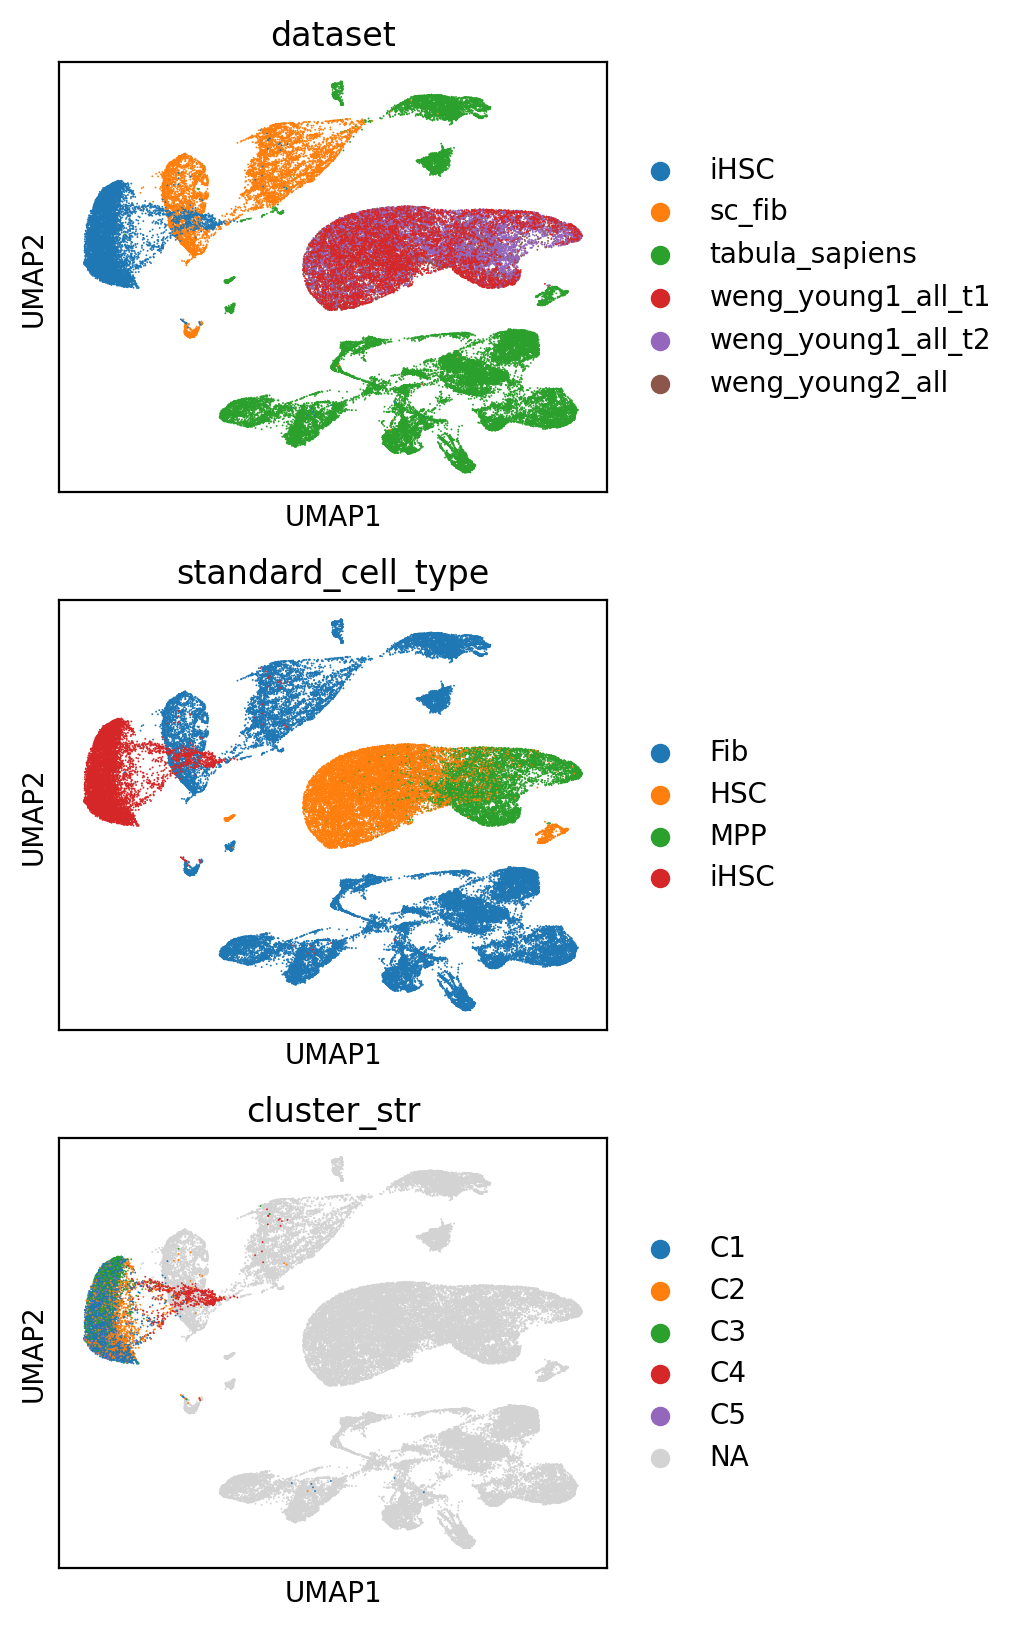

In [5]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3

sc.pl.umap(
    adata, 
    color=[
        'dataset',
        'standard_cell_type',
        'cluster_str',
    ],
    ncols=1,
)

In [6]:
# break

# Subset

In [7]:
keep_types = [
    'iHSC',
    'Fib',
    'HSC',
]

exclude_datasets = [
    'tabula_sapiens',
]

mask = (adata.obs['standard_cell_type'].isin(keep_types)) & (~adata.obs['dataset'].isin(exclude_datasets))
bdata = adata[mask, :].copy()

# sort the cells by type
sorted_indices = bdata.obs['standard_cell_type'].argsort()
bdata = bdata[sorted_indices, :].copy() 

sc.tl.embedding_density(bdata, basis='umap')

# establish grouping
bdata.obs['group'] = np.where(bdata.obs['cluster_str'].isin(['C2', 'C5']), "HSC-like", "HSC")
bdata.obs['group'] = np.where(bdata.obs['standard_cell_type'].isin(['Fib']), "Fib", bdata.obs['group'])
bdata.obs['group'].value_counts()

computing density on 'umap'
--> added
    'umap_density', densities (adata.obs)
    'umap_density_params', parameter (adata.uns)


group
HSC         20474
Fib          7736
HSC-like     2196
Name: count, dtype: int64

# Embed

... storing 'group' as categorical


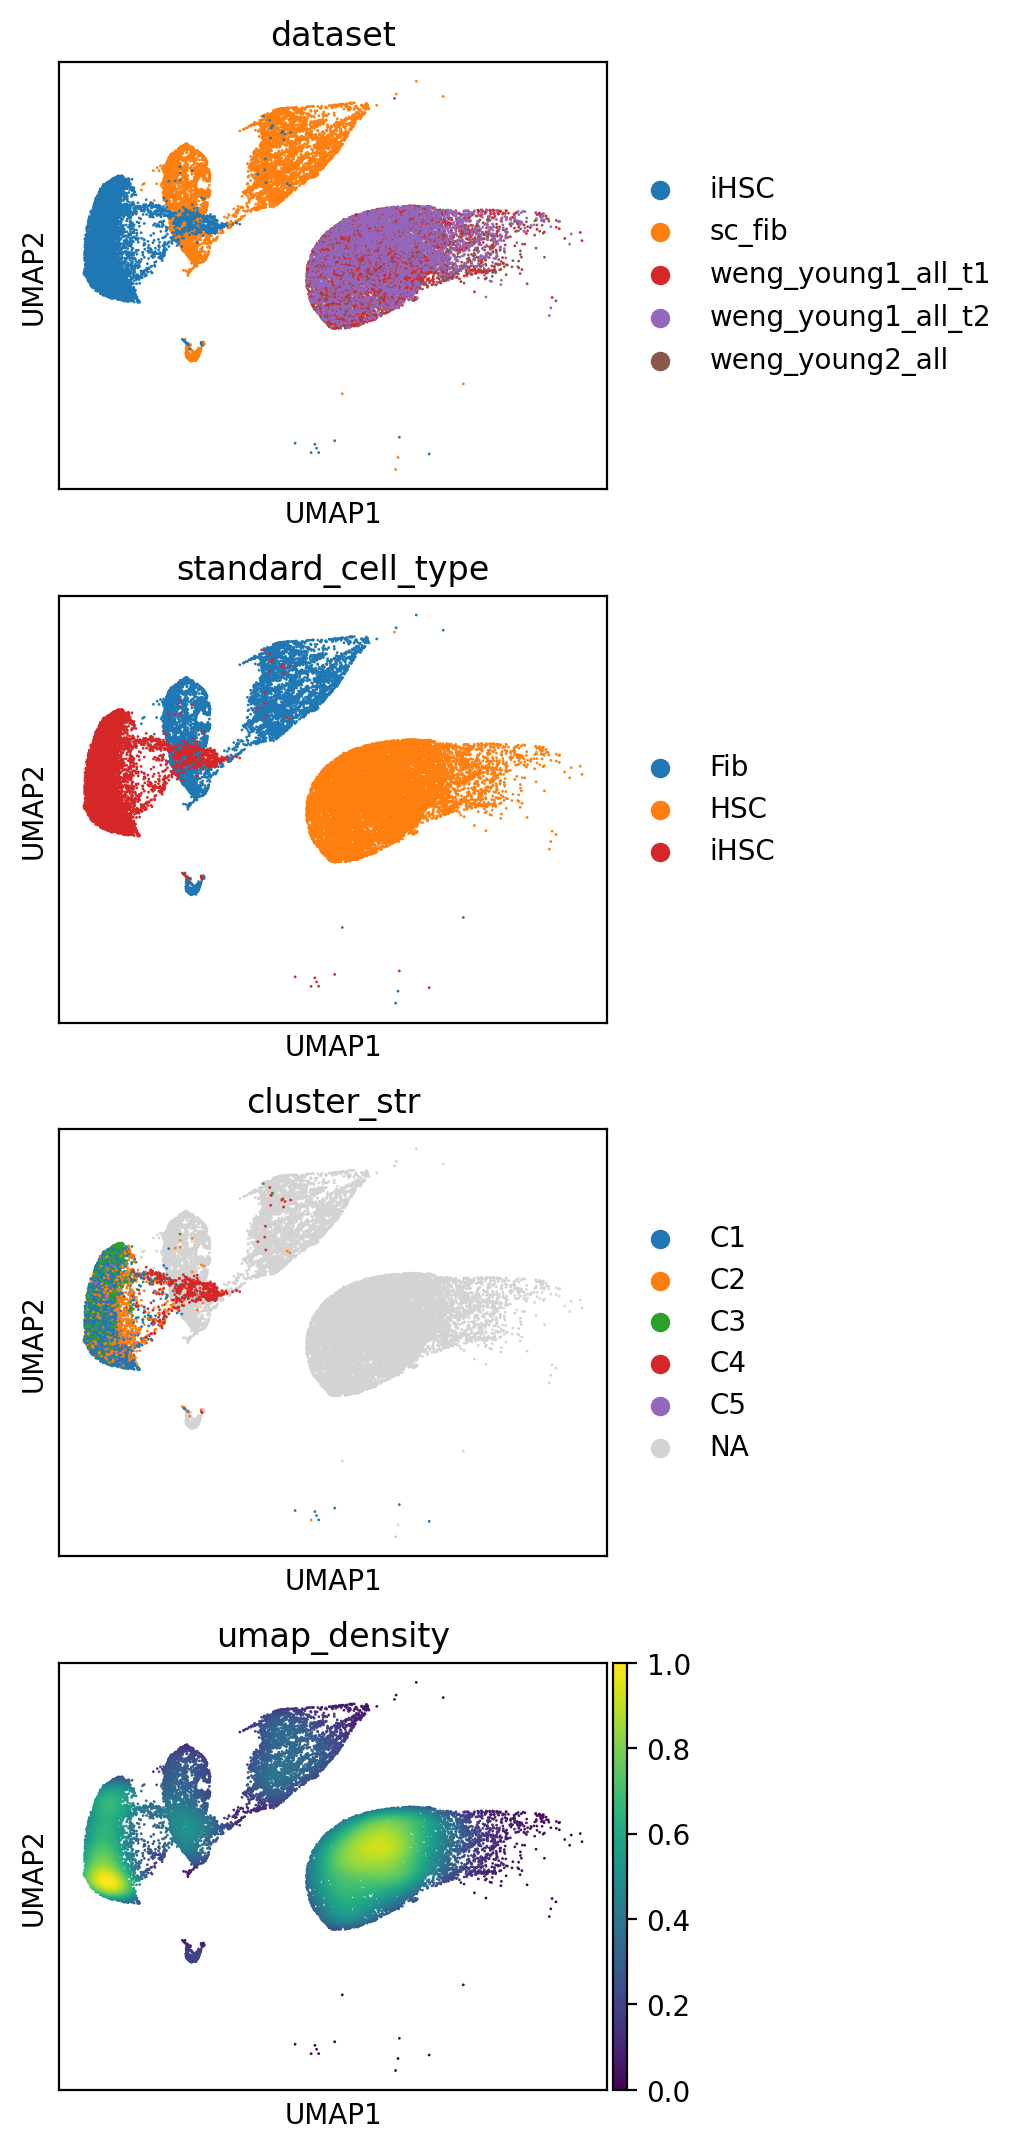

In [8]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3

sc.pl.umap(
    bdata, 
    color=[
        'dataset',
        'standard_cell_type',
        'cluster_str',
        'umap_density',
    ],
    ncols=1,
)

,n_genes,dataset,n_genes_by_counts,total_counts,obs_index,cell_type,standard_cell_type,cell_label,_scvi_batch,_scvi_labels,batch,UMAP_1,UMAP_2,cluster_str,umap_density,group
ACGCCTAGTTGGACGG_sc_fib,2247,sc_fib,2247,12259.632965,ACGCCTAGTTGGACGG,sc_fib,Fib,Fib,4,0,0,-11.094510,5.497536,NaN,0.473761,Fib
CAGTCCTCAACGGCTA_sc_fib,3351,sc_fib,3351,17040.570886,CAGTCCTCAACGGCTA,sc_fib,Fib,Fib,4,0,0,-5.515329,7.231917,NaN,0.301177,Fib
CAGTCCTCACCTTAGC_sc_fib,3798,sc_fib,3798,18315.512332,CAGTCCTCACCTTAGC,sc_fib,Fib,Fib,4,0,0,-5.403408,7.827496,NaN,0.351300,Fib
CAGTCCTCATAGGCGC_sc_fib,4024,sc_fib,4024,19485.019914,CAGTCCTCATAGGCGC,sc_fib,Fib,Fib,4,0,0,-5.646887,6.610879,NaN,0.213628,Fib
CAGTCCTCATGACAGT_sc_fib,2299,sc_fib,2299,12310.620754,CAGTCCTCATGACAGT,sc_fib,Fib,Fib,4,0,0,-5.561289,10.828295,NaN,0.327478,Fib


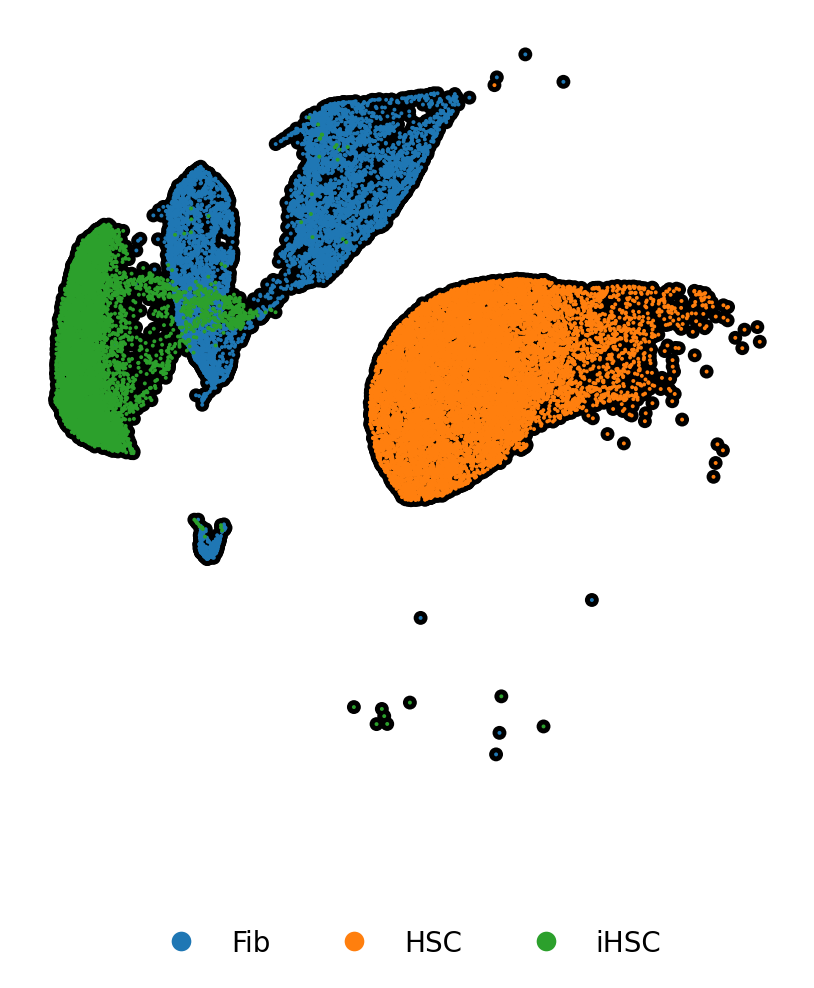

In [9]:
pdf = bdata.obs.copy()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

sns.scatterplot(
    data=pdf,
    x='UMAP_1',
    y='UMAP_2',
    c='k',
    ec='none',
    s=25,
)

sns.scatterplot(
    data=pdf,
    x='UMAP_1',
    y='UMAP_2',
    hue='standard_cell_type',
    s=2,
    ec='none',
)

plt.xticks([])
plt.yticks([])

plt.ylabel('UMAP 2')
plt.xlabel('UMAP 1')
plt.gca().set_aspect('auto')
plt.axis(False)

sns.move_legend(
    plt.gca(),
    loc='lower center',
    title="",
    frameon=False,
    bbox_to_anchor=(0.5, -0.25),
    markerscale=5,
    ncol=5
)

pdf.head()

# scANVI Embedding

In [10]:
# space = 'X_scANVI'
# n = bdata.obsm[space].shape[1]
# numbers = list(range(n))
# indices = list(itertools.combinations(numbers, 2))
# print(len(indices))

# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 15, 15
# fig, axs = plt.subplots(4, 4)
# axs = axs.ravel()

# for pi, (i, j) in enumerate(indices[:16]):
#     sns.scatterplot(
#         data=bdata.obs,
#         x=bdata.obsm[space][:, i],
#         y=bdata.obsm[space][:, j],
#         hue='standard_cell_type',
#         ec='none',
#         ax=axs[pi],
#         s=2,
#         legend=False,
#     )

#     axs[pi].set_title(f"{space} {i+1} vs. {j+1}")
#     axs[pi].axis(False)


# plt.tight_layout()

# Distances

In [11]:
target_type = 'HSC'
target = bdata[bdata.obs['standard_cell_type'] == target_type, :].copy()

X = bdata.obsm['X_scANVI']
X_target = target.obsm['X_scANVI']

print(f"{X.shape=}")
print(f"{X_target.shape=}")

metric = 'cosine'

D = cdist(X, X_target, metric)
print(f"{D.shape=}")

ddf = pd.DataFrame({
    'cell_id' : bdata.obs_names,
    'cell_type' : bdata.obs['standard_cell_type'].values,
    'cluster_str' : bdata.obs['cluster_str'].values,
    'mean_dist' : D.mean(axis=1),
    'min_dist' : D.min(axis=1),
    'max_dist' : D.max(axis=1),
})

ddf = ddf.sort_values(by='cell_type')
ddf.head()

X.shape=(30406, 24)
X_target.shape=(14350, 24)
D.shape=(30406, 14350)


,cell_id,cell_type,cluster_str,mean_dist,min_dist,max_dist
0,ACGCCTAGTTGGACGG_sc_fib,Fib,NaN,1.262853,0.333760,1.681414
5164,TGTGTTGAGCCTATCT_sc_fib,Fib,NaN,0.774287,0.176979,1.788860
5163,TGTGTTAGTTTGCGAT_sc_fib,Fib,NaN,0.757172,0.154537,1.811909
5162,TGTGTTAGTTGGTAAG_sc_fib,Fib,NaN,1.301339,0.242358,1.845681
5161,TGTGGTTGTTGAAGGC_sc_fib,Fib,NaN,1.112039,0.362927,1.734560


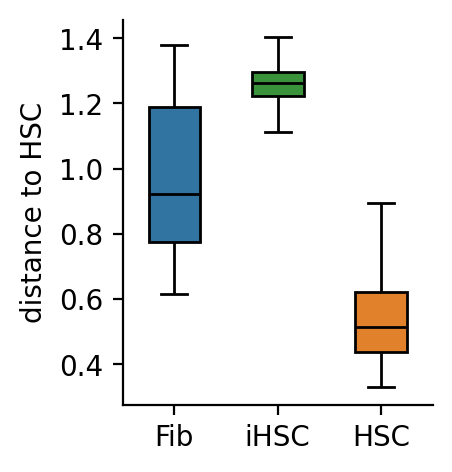

In [12]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 2, 2.5

sns.boxplot(
    data=ddf,
    x='cell_type',
    y='mean_dist',
    hue='cell_type',
    width=0.5,
    linecolor='k',
    order=['Fib', 'iHSC', 'HSC'],
    showfliers=False,
)

plt.xlabel("")
plt.ylabel("distance to HSC")
sns.despine()

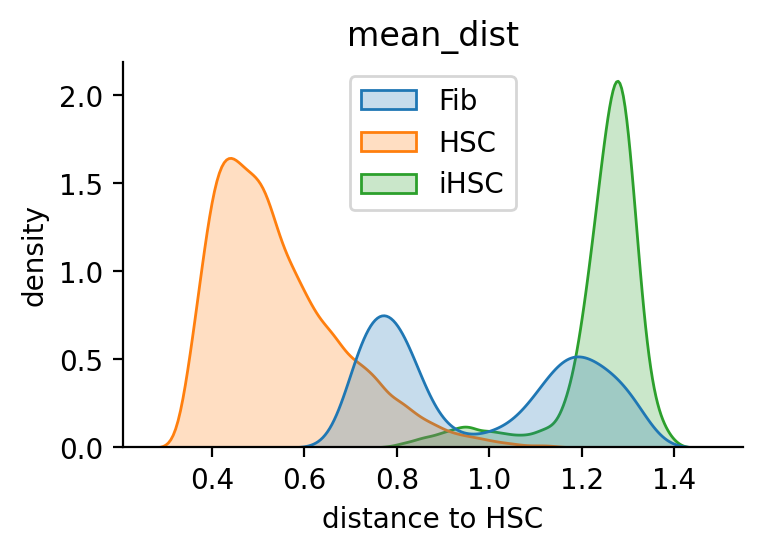

In [13]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 2.5
sns.kdeplot(
    data=ddf,
    x='mean_dist',
    fill=True,
    hue='cell_type',
)

plt.ylabel("density")
plt.xlabel("distance to HSC")
sns.move_legend(
    plt.gca(),
    loc='best',
    title="",
)
plt.title('mean_dist')
sns.despine()


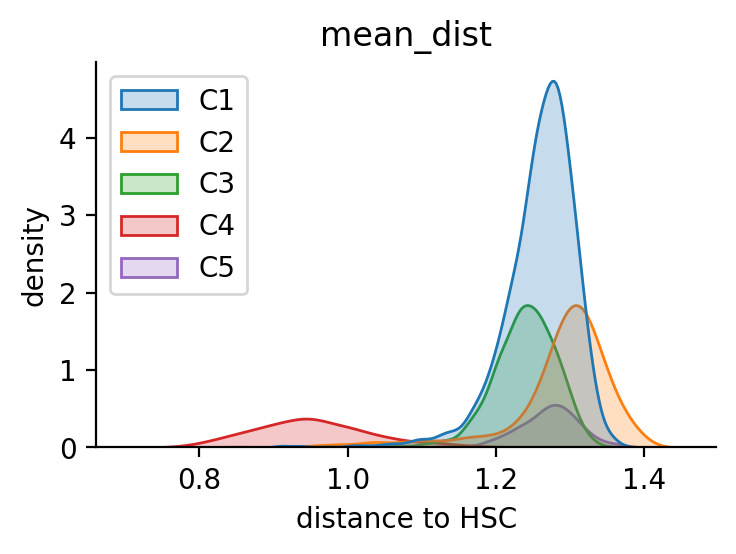

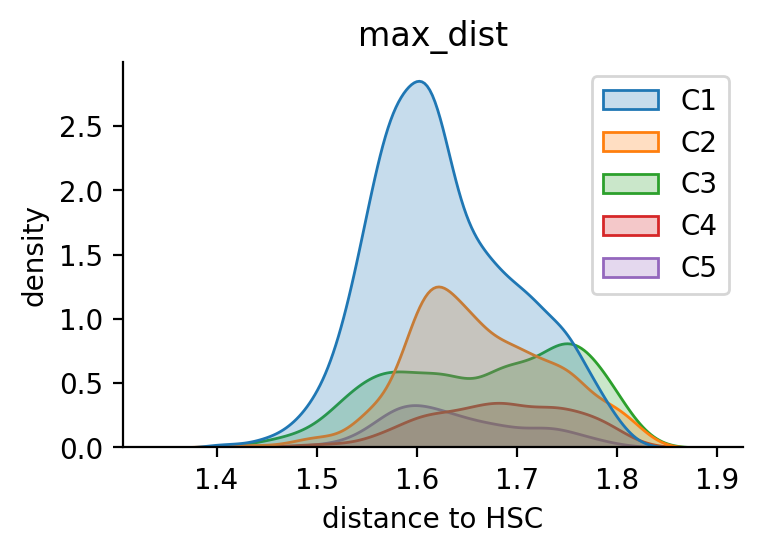

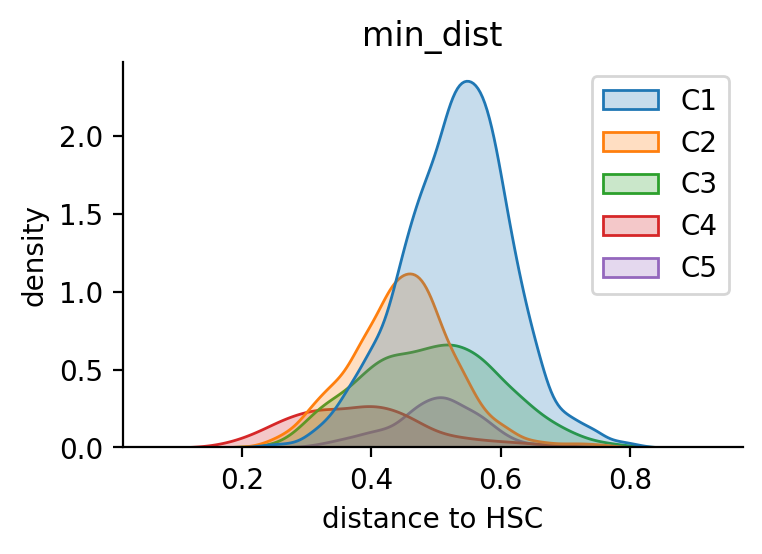

In [14]:
for column in ['mean_dist', 'max_dist', 'min_dist']:

    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 4, 2.5
    sns.kdeplot(
        data=ddf,
        x=column,
        fill=True,
        hue='cluster_str',
    )

    plt.ylabel("density")
    plt.xlabel("distance to HSC")
    sns.move_legend(
        plt.gca(),
        loc='best',
        title="",
    )
    plt.title(column)
    sns.despine()
    plt.show()

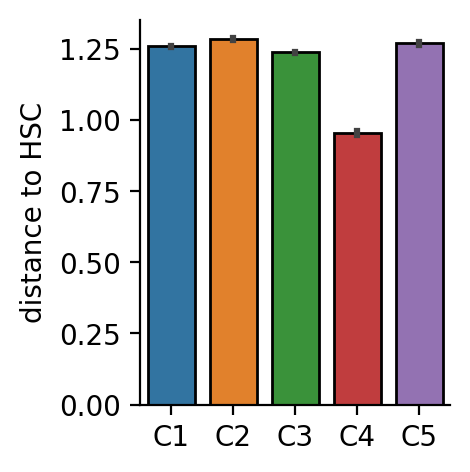

In [15]:
pdf = ddf.copy()
pdf = pdf[pdf['cluster_str'] != 'C6']
pdf = pdf[pdf['cluster_str'].notna()]
pdf['cluster_str'] = pdf['cluster_str'].astype(str)
pdf = pdf.sort_values(by='cluster_str')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 2, 2.5

sns.barplot(
    data=pdf,
    x='cluster_str',
    y='mean_dist',
    hue='cluster_str',
    ec='k',
    width=0.75,
)

plt.xlabel("")
plt.ylabel("distance to HSC")
sns.despine()

In [16]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# relationship distance to expression

In [ ]:
pdf = ddf.copy()
pdf = pdf.sort_values(by='mean_dist')


# sort expression by distance
exp_df = bdata.to_df() 
exp_df = exp_df.loc[pdf['cell_id'].values]
exp_df = exp_df.reset_index(drop=False, names='cell_id')
print(f"{exp_df.shape=}")
exp_df['rank'] = range(len(exp_df))
exp_df = pd.merge(
    exp_df, pdf, how='left'
)
print(f"{exp_df.shape=}")
exp_df.head()

In [ ]:
reload(ut)
fpath = "../resources/PanglaoDB_Augmented_2021.txt"
features = ut.load_pathway(fpath)

[x for x in features.columns if 'hemato' in x.lower()]

pathway = 'Hematopoietic Stem Cells'
query_genes = list(features[features[pathway]].index)
print(len(query_genes))
query_genes[:10]

In [ ]:
results = []
target_column = 'mean_dist' 

for column in exp_df.columns:
    if column not in  adata.var_names:
      continue
    
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
        exp_df[target_column], 
        exp_df[column],
    )
    results.append({
        'gene_name': column, 
        'intercept' : intercept,
        'r_value': r_value,
        'p_value': p_value,
        'slope': slope,
        'std_err' : std_err,
    })

results = pd.DataFrame(results)
print(f"{results.shape=}")
results = results.sort_values(by='slope')
results['is_marker'] = results['gene_name'].isin(query_genes)
results.head(15)

In [ ]:
results[results['is_marker']].head(10)

In [ ]:
break

In [ ]:
gene_list = [
    'MEIS1',
    'CD34',
    'RUNX1',
    'KIT',
    'PROM1',
    'MGST1',
]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, (len(gene_list) * 1.5)

fig, axs = plt.subplots(len(gene_list), 1, sharex=True)
axs = axs.ravel()

window = 2500

for i, g in enumerate(gene_list):
    scaler = MinMaxScaler()  
    normed = scaler.fit_transform(exp_df[g].values.reshape(-1, 1)).flatten()
    smoothed = np.convolve(normed, np.ones(window), 'valid')
    rolling_avg = smoothed / window
    nan_padding = np.full(window - 1, np.nan)
    smoothed = np.concatenate((nan_padding, rolling_avg))
    
    sns.scatterplot(
        data=exp_df, 
        x='rank',
        y=normed,
        hue='cell_type',
        legend=False,
        alpha=0.2,
        s=3,
        ec='none',
        ax=axs[i],
    )
    
    sns.lineplot(
        data=exp_df, 
        x='rank',
        y=smoothed,
        c='k',
        lw=1.5,
        ax=axs[i],
    )
    
    axs[i].set_title(g, fontsize=10,)
    axs[i].set_xlabel('distance (rank)')
    axs[i].set_ylabel('')
    axs[i].set_yticks([])

plt.xticks([])
sns.despine(left=True)
plt.tight_layout()

In [ ]:
break

# Predictions

In [ ]:
fpath = "/scratch/indikar_root/indikar1/shared_data/sc_HSC/SCANVI/ihsc_predictions.csv"

pred = pd.read_csv(fpath)
pred['cluster'] = pred['cell_id'].map(cluster_map)
pred = pred[pred['cluster'] != 'C6']

pred = pd.pivot_table(
    pred, 
    index='cluster',
    columns='prediction',
    values='cell_id',
    aggfunc='count',
    fill_value=0.0,
)

pred = pred.div(pred.sum(axis=1), axis=0) * 100
pred
# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 5, 4

# sns.heatmap(
#     data=pred,
#     lw=1,
#     annot=True,
#     square=True,
#     cbar=False,
#     fmt=".2f",
#     annot_kws={'fontsize' : 8},
#     vmax=5,
#     cmap='viridis_r',
# )

# plt.gca().tick_params(axis='y', rotation=0)
# plt.ylabel("")
# plt.xlabel("")



In [ ]:
break

# Targeted Distances

In [ ]:
init = adata[adata.obs['dataset'] == 'sc_fib', :].copy()
target = adata[adata.obs['standard_cell_type'] == 'HSC', :].copy()
ihsc = adata[adata.obs['standard_cell_type'] == 'iHSC', :].copy()

X_init = init.obsm['X_scANVI']
X_target = target.obsm['X_scANVI']
X_ihsc = ihsc.obsm['X_scANVI']

print(f"{X_init.shape=}")
print(f"{X_target.shape=}")
print(f"{X_ihsc.shape=}")

In [ ]:
metric = 'cosine'

D_target = cdist(X_ihsc, X_target, metric)
D_init = cdist(X_ihsc, X_init, metric)

ddf = pd.DataFrame({
    'cell_id' : ihsc.obs_names,
    'mean_target' : D_target.mean(axis=1),
    'min_target' : D_target.min(axis=1),
    'max_target' : D_target.max(axis=1),
    'mean_init' : D_init.mean(axis=1),
    'min_init' : D_init.min(axis=1),
    'max_init' : D_init.max(axis=1),
})
ddf['cluster'] = ddf['cell_id'].map(cluster_map)
ddf.head()

In [ ]:
pdf = ddf.copy()

pdf = pd.melt(
    pdf, 
    id_vars='cell_id', 
    value_vars=['mean_target', 'mean_init'],
)

label_map = {
    'mean_target' : 'target',
    'mean_init' : 'initial',
}

pdf['label'] = pdf['variable'].map(label_map)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 1.5

sns.kdeplot(
    data=pdf,
    # bins=31,
    x='value',
    hue='label',
    fill=True,
    # kde='True',
    # palette=['#a0f080', '#ffa500'],
    # palette = ['#80e040', '#ff8000'],
    palette = ['green', 'orange']

)

plt.xlabel("mean distance")
plt.ylabel("")
plt.yticks([])

sns.move_legend(
    plt.gca(),
    title="",
    loc='best',
    frameon=False,
)

sns.despine(left=True)

In [ ]:
pdf = ddf.copy()

pdf = pd.melt(
    pdf, 
    id_vars=['cell_id', 'cluster'], 
    value_vars=['mean_target', 'mean_init'],
)

pdf = pdf[pdf['cluster'] != 'C6']

label_map = {
    'mean_target' : 'target',
    'mean_init' : 'initial',
}

pdf['label'] = pdf['variable'].map(label_map)
pdf = pdf.sort_values(by='cluster')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 1.7, 2.25

sns.barplot(
    data=pdf,
    x='cluster',
    y='value',
    hue='label',
    width=0.5,
    ec='k',
    palette = ['green', 'orange'],
)

plt.ylabel("mean distance")
plt.xlabel("")

sns.move_legend(
    plt.gca(),
    title="",
    loc='upper center',
    ncol=2,
    frameon=False,
    bbox_to_anchor=(0.5, 1.25)
)

sns.despine()

In [ ]:
# break

# Sort by distance

In [ ]:
reload(ut)
fpath = "../resources/CellMarker_2024.txt"
features = ut.load_pathway(fpath)

[x for x in features.columns if 'hemato' in x.lower()]

pathway = "Hematopoietic Stem Cell Bone Marrow Human"
# pathway = "Bone Marrow-hematopoietic Stem Cell"
# pathway = 'Hematopoietic Stem Cells'
# pathway = 'Fibroblasts'
query_genes = list(features[features[pathway]].index)
print(len(query_genes))
query_genes[:10]

In [ ]:
pdf = ddf.copy()
pdf = pdf.sort_values(by='mean_target')

# sort expression by distance
exp_df = bdata.to_df(layer='SCANVI_counts')
exp_df = exp_df.loc[pdf['cell_id'].values]
exp_df = exp_df.reset_index(drop=False, names='cell_id')
print(f"{exp_df.shape=}")
exp_df['rank'] = range(len(exp_df))
exp_df = pd.merge(
    exp_df, pdf, how='left'
)
exp_df.head()

In [ ]:
results = []

for column in exp_df.columns:
    if column not in  adata.var_names:
      continue
    
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
        exp_df['mean_target'], 
        exp_df[column],
    )
    results.append({
        'gene_name': column, 
        'intercept' : intercept,
        'r_value': r_value,
        'p_value': p_value,
        'slope': slope,
        'std_err' : std_err,
    })

results = pd.DataFrame(results)
print(f"{results.shape=}")
results = results.sort_values(by='slope')
# results = results[results['gene_name'].isin(query_genes)]
results.head(15)

In [ ]:
break

In [ ]:
# database = 'ontology'
# n_genes = 50
# top_genes = results['gene_name'].head(n_genes)
# top_genes = list(top_genes)

# edf = gget.enrichr(top_genes, database=database)
# pd.set_option('display.max_colwidth', 100) 
# edf[['path_name', 'adj_p_val', 'overlapping_genes']].head(15)

In [ ]:
gene_list = [
    'KLF1',
    'ATG12',
    'CD34',
    'KIT',
    'GFI1',
    'GATA2'
]


def abline(slope, intercept):
  """Plot a line from slope and intercept"""
  x_vals = np.linspace(0, 10000)
  y_vals = intercept + slope * x_vals
  plt.plot(x_vals, y_vals, ls='--', zorder=5)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3

for i, g in enumerate(gene_list):
    
    slope = results[results['gene_name'] == g]['slope'].values[0]
    intercept = results[results['gene_name'] == g]['intercept'].values[0]
    x_vals = np.linspace(0, 10000)
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, ls='--', label=g, zorder=5)


plt.legend()

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 12

fig, axs = plt.subplots(6, 1, sharex=True)
axs = axs.ravel()

gene_list = [
    'KLF1',
    'ATG12',
    'CD34',
    'KIT',
    'GFI1',
    'GATA2'
]


window = 500

for i, g in enumerate(gene_list):
    scaler = MinMaxScaler()  
    normed = scaler.fit_transform(exp_df[g].values.reshape(-1, 1)).flatten()
    smoothed = np.convolve(normed, np.ones(window), 'valid')
    rolling_avg = smoothed / window
    nan_padding = np.full(window - 1, np.nan)
    smoothed = np.concatenate((nan_padding, rolling_avg))
    
    sns.scatterplot(
        data=exp_df, 
        x='rank',
        y=normed,
        hue=''
        alpha=0.2,
        s=3,
        ec='none',
        ax=axs[i],
    )
    
    sns.lineplot(
        data=exp_df, 
        x='rank',
        y=smoothed,
        c='r',
        ax=axs[i],
    )
    
    axs[i].set_title(g)
    axs[i].set_xlabel('distance (rank)')
    axs[i].set_ylabel('')
    axs[i].set_yticks([])

sns.despine(left=True)
plt.tight_layout()

# Predictions

In [ ]:
fpath = "/scratch/indikar_root/indikar1/shared_data/sc_HSC/SCANVI/ihsc_predictions.csv"

pred = pd.read_csv(fpath)
pred['cluster'] = pred['cell_id'].map(cluster_map)
pred = pred[pred['cluster'] != 'C6']

pred = pd.pivot_table(
    pred, 
    index='cluster',
    columns='prediction',
    values='cell_id',
    aggfunc='count',
    fill_value=0.0,
)

pred = pred.div(pred.sum(axis=1), axis=0) * 100

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 4

sns.heatmap(
    data=pred,
    lw=1,
    annot=True,
    square=True,
    cbar=False,
    fmt=".2f",
    annot_kws={'fontsize' : 8},
    vmax=5,
    cmap='viridis_r',
)

plt.gca().tick_params(axis='y', rotation=0)
plt.ylabel("")
plt.xlabel("")



# Visualize expression

In [ ]:
def plot_gene_expression(exp_df, pdf, gene, cmap='viridis', vmin=None, vmax=None, ax=None, colorbar=True):
    """
    Plots gene expression on UMAP coordinates with color gradient.

    Args:
        exp_df: DataFrame containing gene expression data.
        pdf: DataFrame containing UMAP coordinates.
        gene: The gene to plot.
    """
    vector = exp_df[gene].values
    sorted_idx = np.argsort(vector)
    if vmax is None:
        vmax = vector.max()
    if vmin is None:
        vmin = vector.min()

    print(f"{vmax=:.5f} {vmin=:.5f}")
    if ax is None:
        fig, ax = plt.subplots()

    # Base scatterplot (black dots)
    sns.scatterplot(
        data=pdf,
        x='scANVI_UMAP_1',
        y='scANVI_UMAP_2',
        ec='k',
        color='k',
        s=25,
        zorder=1,
        ax=ax,
    )

    # Expression-colored scatterplot
    sns.scatterplot(
        data=pdf.iloc[sorted_idx],
        x='scANVI_UMAP_1',
        y='scANVI_UMAP_2',
        ec='none',
        hue=vector[sorted_idx],
        palette=cmap,
        s=8,
        zorder=1,
        hue_norm=(vmin, vmax),
        legend=False,
        ax=ax,
    )

    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_title(gene)
    sns.despine(left=True, bottom=True)


    if colorbar:
        # Create colorbar
        norm = plt.Normalize(vmin, vmax)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])  # This is necessary for the colorbar to work

        # Add colorbar to the plot
        cbar = ax.figure.colorbar(sm, ax=ax, shrink=0.45)
    
    plt.axis('auto')

In [ ]:
gene_list = [
    # 'AVP',
    # 'CRHBP',
    'CD34',
    
]

layer = 'SCANVI_counts'
density_thr = 0.05

pdf = bdata.obs.copy()
mask = pdf['umap_density'] > density_thr
exp_df = bdata[:, gene_list].to_df(layer=layer)

for gene in gene_list:
    print(f"==== {gene} ====")
    stat = exp_df[mask][gene].describe(percentiles=[0.1, 0.5, 0.53, 0.9, 0.95, 0.99])
    # print(stat)
    # print()

    vmax = stat.loc['53%']

    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 6, 3

    plot_gene_expression(
        exp_df[mask], 
        pdf[mask], 
        gene, 
        vmin=0,
        vmax=vmax,
        cmap='viridis', 
        colorbar=False,
    )

    break

In [ ]:
break